In [1]:
import numpy as np
import pandas as pd
#import gensim
import matplotlib.pyplot as plt
import seaborn as sns
#from nltk.tokenize import word_tokenize
#from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pyarrow.parquet as pq
import geopandas

In [37]:
data2020=pd.read_pickle("data2020.pkl", compression='infer')
data2019=pd.read_pickle("data2019.pkl", compression='infer')


In [38]:
data2018=pd.read_pickle("data2018.pkl", compression='infer')

In [39]:
data2017=pd.read_pickle("data2017.pkl", compression='infer')

In [40]:
data17_18=data2017.append(data2018, ignore_index = True)

In [41]:
data19=data17_18.append(data2019, ignore_index=True)

In [42]:
data=data19.append(data2020, ignore_index=True)

In [7]:
QID = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')


,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America
...,...,...
Q106302506,didgeridooist,musician who plays the didgeridoo
Q106341153,biochemistry teacher,teacher of biochemistry at any level
Q106368830,2018 Wigan Metropolitan Borough Council electi...,NaN


In [8]:
speaker_df = pd.read_parquet("speaker_attributes.parquet", engine='pyarrow')


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055976,[Barker Howard],None,[Q30],[Q6581097],1397399351,None,None,[Q82955],None,None,Q106406560,Barker B. Howard,None,item,None
9055977,[Charles Macomber],None,[Q30],[Q6581097],1397399471,None,None,[Q82955],None,None,Q106406571,Charles H. Macomber,None,item,None
9055978,None,[+1848-04-01T00:00:00Z],None,[Q6581072],1397399751,None,None,None,None,None,Q106406588,Dina David,None,item,None
9055979,None,[+1899-03-18T00:00:00Z],None,[Q6581072],1397399799,None,None,None,None,None,Q106406593,Irma Dexinger,None,item,None


In [9]:
len(speaker_df)

9055981

In [10]:
speaker_df=speaker_df.drop_duplicates(subset=['label'])

In [11]:
len(speaker_df)

7287299

### Parties talking about global warming

In [43]:
sort=data['speaker'].value_counts().to_frame('counts').reset_index()
sort = sort.rename(columns={'index': 'label'})
sort

,label,counts
0,Bernie Sanders,750
1,Jay Inslee,690
2,Catherine McKenna,541
3,Michael Mann,523
4,Antonio Guterres,516
...,...,...
23756,Paul Gallagher,1
23757,Ilje Pikaar,1
23758,Benoît Bertrand,1
23759,Tim Blair,1


In [44]:
top_speakers_inorder = pd.merge(sort, speaker_df, how='left', on='label')

In [45]:
party=top_speakers_inorder[['party','counts']]


In [46]:

party=party.explode(column='party')
party = party.rename(columns={'party': 'QID'})
party=party.dropna()


In [47]:
party=party.groupby(['QID'])['counts'].sum().to_frame()
party.sort_values(by='counts',ascending=False)



,counts
QID,
Q29552,13629
Q29468,4627
Q327591,2116
Q138345,1662
Q9626,883
...,...
Q1146616,1
Q2306078,1
Q6164619,1


In [18]:
final=pd.merge(party, QID, on='QID')
final=final.sort_values(by='counts',ascending=False)


,counts,Label,Description
QID,,,
Q29552,12411,Democratic Party,political party in the United States
Q29468,4398,Republican Party,major political party in the United States
Q327591,1765,independent politician,individual not affiliated to any political party
Q138345,1588,Liberal Party of Canada,oldest federal political party in Canada
Q10230,828,Bharatiya Janata Party,major political party in India
...,...,...,...
Q1290162,1,Pro-Administration Party,political party
Q1288287,1,New National Party,political party in Grenada
Q493685,1,Centre Party,centrist and agrarian political party in Norway


<AxesSubplot:xlabel='Label'>

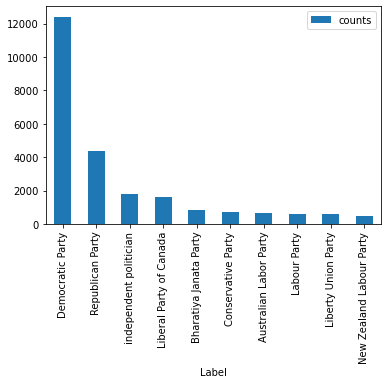

In [48]:

final[:10].plot(kind='bar',x='Label',y='counts')


### Using governors of each state

In [166]:
scores=pd.read_csv('states_scores.csv', delimiter=';')


In [167]:
governors=pd.read_csv('governors.csv', delimiter=';')
governors=governors.dropna(how='all')


In [168]:
governors = governors.rename(columns={'name': 'label', 'party':'political_party', 'state_name':'state'})


In [169]:

governors_inorder = pd.merge(governors, top_speakers_inorder, how='left', on='label')


In [170]:

governors_inorder=governors_inorder.sort_values(by='counts', ascending=False)
governors_inorder=governors_inorder[['state', 'label', 'counts', 'political_party']]


In [171]:
scores_governors=pd.merge(governors_inorder, scores, how='left', on='state')

In [277]:
states = geopandas.read_file('data/usa-states-census-2014.shp')
states=states.rename(columns={'NAME': 'state'})


In [279]:

states.crs

{'init': 'epsg:4326'}

In [280]:
states=states.to_crs(epsg=3395)

In [271]:
stat

RuntimeError: b'no arguments in initialization list'

In [239]:
states_scores=pd.merge(states, scores_governors, how='left', on='state')


In [240]:
states_scores

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,state,LSAD,ALAND,AWATER,region,geometry,label,counts,political_party,rank,score,environmental,eco_friendly,climate_change,party
0,06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881,West,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,...",Gavin Newsom,176.0,democrat,5.0,72.90,28.0,3.0,3.0,Democratic Party
1,11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500,Northeast,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551,Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ...",Ronald DeSantis,NaN,republican,42.0,49.45,29.0,43.0,39.0,Republican Party
3,13,01705317,0400000US13,13,GA,Georgia,00,148963503399,4947080103,Southeast,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47...",Brian Kemp,NaN,republican,33.0,54.02,31.0,42.0,21.0,Democratic Party
4,16,01779783,0400000US16,16,ID,Idaho,00,214045425549,2397728105,West,"POLYGON Z ((-117.24303 44.39097 0.00000, -117....",Brad Little,NaN,republican,25.0,58.75,40.0,32.0,10.0,Republican Party
5,17,01779784,0400000US17,17,IL,Illinois,00,143794747023,6200927458,Midwest,"POLYGON Z ((-91.50617 40.20064 0.00000, -91.49...",J.B. Pritzker,9.0,democrat,23.0,59.34,26.0,20.0,27.0,Democratic Party
6,19,01779785,0400000US19,19,IA,Iowa,00,144668594415,1076856589,Midwest,"POLYGON Z ((-96.62187 42.77925 0.00000, -96.57...",Kimberly Reynolds,NaN,republican,30.0,56.47,17.0,14.0,42.0,Republican Party
7,21,01779786,0400000US21,21,KY,Kentucky,00,102262419204,2393338940,Southeast,"POLYGON Z ((-89.54443 36.57451 0.00000, -89.47...",Andy Beshear,2.0,democrat,46.0,38.17,39.0,48.0,45.0,Republican Party
8,22,01629543,0400000US22,22,LA,Louisiana,00,111901043977,23750204105,Southeast,"POLYGON Z ((-94.04305 32.69303 0.00000, -94.04...",John Edwards,3.0,democrat,49.0,26.34,48.0,50.0,49.0,Republican Party
9,24,01714934,0400000US24,24,MD,Maryland,00,25147575220,6983455225,Northeast,"MULTIPOLYGON Z (((-76.04621 38.02553 0.00000, ...",Lawrence Hogan,NaN,republican,4.0,73.51,7.0,5.0,8.0,Democratic Party


In [195]:
states_scores['logarithm_count'] = np.log(states_scores['counts'].replace(0, np.nan))

max_value = states_scores['logarithm_count'].max()
min_value = states_scores['logarithm_count'].min()
states_scores['logarithm_count'] = (states_scores['counts'] - min_value) / (max_value - min_value)


max_value = states_scores['score'].max()
min_value = states_scores['score'].min()
states_scores['score'] = (states_scores['score'] - min_value) / (max_value - min_value)

(-127.6146362, -64.0610978, 23.253819649999997, 50.628669349999996)

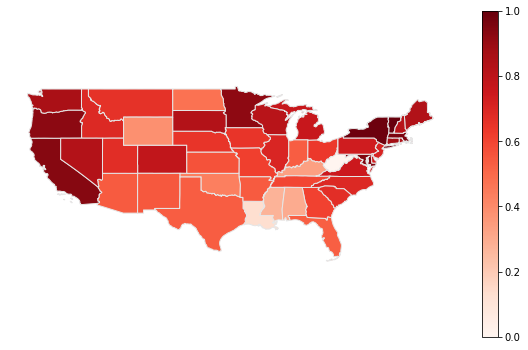

In [196]:
fig, ax = plt.subplots(1, figsize=(10,6))
states_scores.plot(column='score', cmap='Reds', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.axis('off')

<AxesSubplot:>

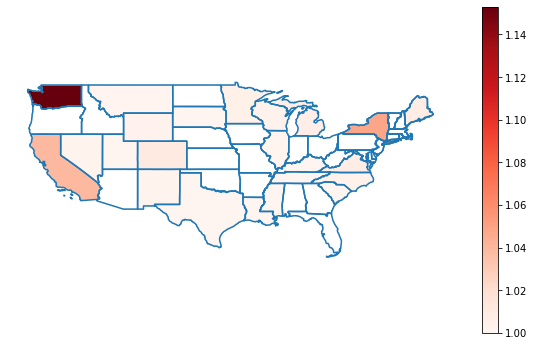

In [197]:
ig, ax = plt.subplots(1, figsize=(10,6))

states_scores.plot(column='logarithm_count', cmap='Reds', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.axis('off')
states_scores.boundary.plot(ax=ax)

In [180]:
senators=pd.read_csv('senators.csv', delimiter=';')
senators=senators.rename(columns={'Name': 'label', 'State':'state'})
senators = senators.drop(senators.columns[[4, 5]], axis=1)
senators

,state,label,Party,Date assumed office
0,Alabama,Richard Shelby,Republican,1987
1,Alabama,Tommy Tuberville,Republican,"January 3, 2021"
2,Alaska,Lisa Murkowski,Republican,"December 20, 2002"
3,Alaska,Daniel S. Sullivan,Republican,"January 6, 2015"
4,Arizona,Mark Kelly,Democratic,"December 2, 2020"
...,...,...,...,...
95,West Virginia,Joe Manchin III,Democratic,"November 15, 2010"
96,Wisconsin,Tammy Baldwin,Democratic,"January 3, 2013"
97,Wisconsin,Ronald Harold Johnson,Republican,2011
98,Wyoming,John Barrasso,Republican,"June 25, 2007"


### Using senators

In [183]:
senators = pd.merge(senators, top_speakers_inorder, how='left', on='label')


In [184]:
senators_inorder=senators.sort_values(by='counts', ascending=False)

In [185]:
scores_senators=pd.merge(senators_inorder, scores, how='left', on='state')
scores_senators=scores_senators.groupby(['state'])['counts'].sum().to_frame()


In [192]:
states_scores2=pd.merge(states, scores_senators, how='left', on='state')
states_scores2['logarithm_count'] = np.log(states_scores2['counts'].replace(0, np.nan))
max_value = states_scores2['logarithm_count'].max()
min_value = states_scores2['logarithm_count'].min()
states_scores2['logarithm_count'] = (states_scores2['logarithm_count'] - min_value) / (max_value - min_value)


(-127.6146362, -64.0610978, 23.253819649999997, 50.628669349999996)

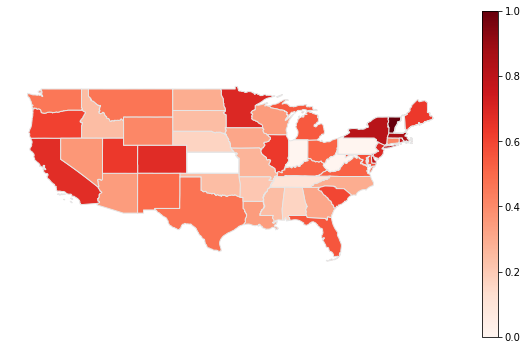

In [193]:
ig, ax = plt.subplots(1, figsize=(10,6))

states_scores2.plot(column='logarithm_count', cmap='Reds', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.axis('off')

(-127.6146362, -64.0610978, 23.253819649999997, 50.628669349999996)

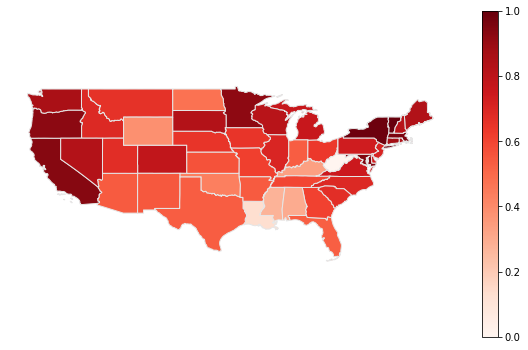

In [188]:
fig, ax = plt.subplots(1, figsize=(10,6))
states_scores.plot(column='score', cmap='Reds', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.axis('off')

### Using senators and governors


In [249]:
states_scores=pd.merge(states, scores_governors, how='left', on='state')

states_scores=states_scores.rename(columns={'counts':'counts2'})



In [250]:
states_scores3= states_scores2.join(states_scores['counts2'])
states_scores3['counts'] = states_scores3['counts'].fillna(0)
states_scores3['counts2'] = states_scores3['counts2'].fillna(0)


In [251]:
states_scores3['total'] = states_scores3['counts'] + states_scores3['counts2'] 


In [252]:
states_scores3['logarithm_count'] = np.log(states_scores3['total'].replace(0, np.nan))

In [253]:
max_value = states_scores3['logarithm_count'].max()
min_value = states_scores3['logarithm_count'].min()
states_scores3['logarithm_count'] = (states_scores3['logarithm_count'] - min_value) / (max_value - min_value)


(-127.6146362, -64.0610978, 23.253819649999997, 50.628669349999996)

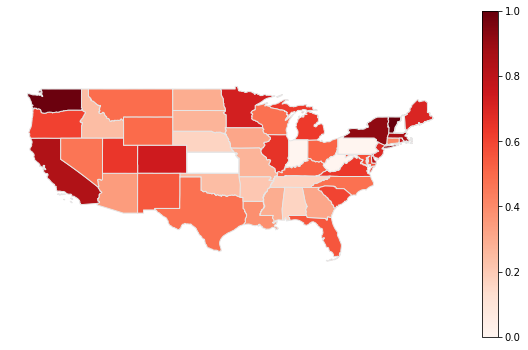

In [254]:
fig, ax = plt.subplots(1, figsize=(10,6))
states_scores3.plot(column='logarithm_count', cmap='Reds', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.axis('off')

(-127.6146362, -64.0610978, 23.253819649999997, 50.628669349999996)

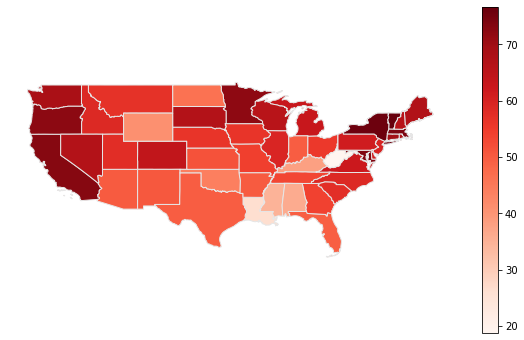

In [255]:
fig, ax = plt.subplots(1, figsize=(10,6))
states_scores.plot(column='score', cmap='Reds', linewidth=1, ax=ax, edgecolor='0.9', legend = True)
ax.axis('off')